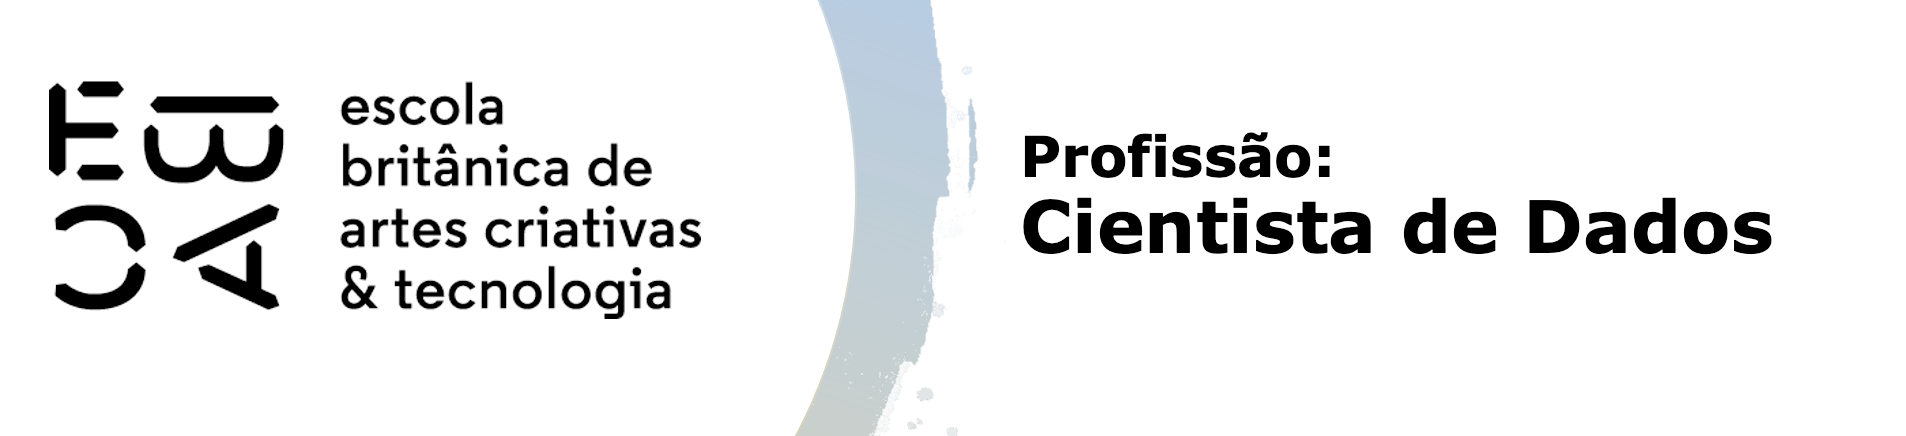

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_pickle('./base_nfp.pkl')
df.head()

CNPJ emit.                                           Emitente  \
0  03.476.811/0741-98                      DIA BRASIL SOCIEDADE LIMITADA   
1  43.101.310/0001-05                         AUTO POSTO ZANWAL LTDA EPP   
2  23.750.257/0001-66  OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE   
3  23.750.257/0001-66  OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE   
4  23.750.257/0001-66  OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE   

    No. Data Emissão  Valor NF Data Registro  Créditos Situação do Crédito  \
0   537   2017-06-30     24.68    2017-06-30      0.00            Liberado   
1  2894   2017-06-30     50.00    2017-06-30      0.00            Liberado   
2   699   2017-06-30     27.00    2017-06-30      0.44            Liberado   
3   698   2017-06-30    111.50    2017-06-30      1.81            Liberado   
4   694   2017-06-30    125.00    2017-06-30      2.03            Liberado   

    Ano  Semestre   Retorno  flag_credito     categoria  
0  2017         1  0.000000             0       Mercado  
1  2017         1  0.000000             0    Auto posto  
2  2017         1  0.016296             1  Restaurantes  
3  2017         1  0.016233             1  Restaurantes  
4  2017         1  0.016240             1  Restaurantes

## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês 
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [3]:
# Criando variável dia da semana
df['Dia da Semana'] = df['Data Registro'].dt.weekday.map({i: dia for i, dia in enumerate(['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo'])})

# Criando flag de fim de semana
df['flag_fds'] = 0
df.loc[df['Dia da Semana'].isin(['Sábado', 'Domingo']), 'flag_fds'] = 1

# Criando variável do dia do mês
df['Dia'] = df['Data Registro'].dt.day

# Criando variável do mês
df['Mês'] = df['Data Registro'].dt.month.map({i: mes for i, mes in enumerate(['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Agosto', 'Junho', 'Julho', 'Setembro', 'Outubro', 'Novembro', 'Dezembro'], start=1)})

# Criando variável do trimestre
q = [3, 6, 9, 12]
df['Trimestre'] = 0
df.loc[df['Data Registro'].dt.month <= q[0] , 'Trimestre'] = 1
df.loc[(df['Data Registro'].dt.month > q[0]) & (df['Data Registro'].dt.month <= q[1]), 'Trimestre'] = 2
df.loc[(df['Data Registro'].dt.month > q[1]) & (df['Data Registro'].dt.month <= q[2]), 'Trimestre'] = 3
df.loc[df['Data Registro'].dt.month > q[2], 'Trimestre'] = 4

df.head(5)

CNPJ emit.                                           Emitente  \
0  03.476.811/0741-98                      DIA BRASIL SOCIEDADE LIMITADA   
1  43.101.310/0001-05                         AUTO POSTO ZANWAL LTDA EPP   
2  23.750.257/0001-66  OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE   
3  23.750.257/0001-66  OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE   
4  23.750.257/0001-66  OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE   

    No. Data Emissão  Valor NF Data Registro  Créditos Situação do Crédito  \
0   537   2017-06-30     24.68    2017-06-30      0.00            Liberado   
1  2894   2017-06-30     50.00    2017-06-30      0.00            Liberado   
2   699   2017-06-30     27.00    2017-06-30      0.44            Liberado   
3   698   2017-06-30    111.50    2017-06-30      1.81            Liberado   
4   694   2017-06-30    125.00    2017-06-30      2.03            Liberado   

    Ano  Semestre   Retorno  flag_credito     categoria Dia da Semana  \
0  2017         1  0.000000             0       Mercado   Sexta-feira   
1  2017         1  0.000000             0    Auto posto   Sexta-feira   
2  2017         1  0.016296             1  Restaurantes   Sexta-feira   
3  2017         1  0.016233             1  Restaurantes   Sexta-feira   
4  2017         1  0.016240             1  Restaurantes   Sexta-feira   

   flag_fds  Dia     Mês  Trimestre  
0         0   30  Agosto          2  
1         0   30  Agosto          2  
2         0   30  Agosto          2  
3         0   30  Agosto          2  
4         0   30  Agosto          2

In [4]:
# Verificando consistência da variável trimestre criada
pd.crosstab(df['Data Registro'].dt.month, df['Trimestre'])

Trimestre          1      2      3      4
Data Registro                            
1              12290      0      0      0
2              11536      0      0      0
3              12245      0      0      0
4                  0  12308      0      0
5                  0  13788      0      0
6                  0  16526      0      0
7                  0      0  14199      0
8                  0      0  19671      0
9                  0      0  21109      0
10                 0      0      0  17454
11                 0      0      0  15768
12                 0      0      0  20752

In [5]:
# Criando variáveis categorizadas da variável Valor NF, por quantís, em 5, 10, 20 e 50 categorias.
df['cat5_Valor NF'] = pd.qcut(df['Valor NF'], 5)
df['cat10_Valor NF'] = pd.qcut(df['Valor NF'], 10)
df['cat20_Valor NF'] = pd.qcut(df['Valor NF'], 20)
df['cat50_Valor NF'] = pd.qcut(df['Valor NF'], 50)

df[['Valor NF', 'cat5_Valor NF', 'cat10_Valor NF', 'cat20_Valor NF', 'cat50_Valor NF']].head(10)

Valor NF       cat5_Valor NF    cat10_Valor NF    cat20_Valor NF  \
0     24.68      (13.36, 28.61]    (20.29, 28.61]     (24.5, 28.61]   
1     50.00       (28.61, 55.0]     (38.88, 55.0]    (46.028, 55.0]   
2     27.00      (13.36, 28.61]    (20.29, 28.61]     (24.5, 28.61]   
3    111.50      (55.0, 131.36]    (81.8, 131.36]  (101.48, 131.36]   
4    125.00      (55.0, 131.36]    (81.8, 131.36]  (101.48, 131.36]   
5     23.80      (13.36, 28.61]    (20.29, 28.61]     (20.29, 24.5]   
6     56.00      (55.0, 131.36]      (55.0, 81.8]     (55.0, 66.52]   
7     49.00       (28.61, 55.0]     (38.88, 55.0]    (46.028, 55.0]   
8    189.00  (131.36, 562500.0]  (131.36, 257.84]  (176.75, 257.84]   
9     25.00      (13.36, 28.61]    (20.29, 28.61]     (24.5, 28.61]   

      cat50_Valor NF  
0     (23.62, 25.14]  
1      (48.0, 50.72]  
2      (26.9, 28.61]  
3    (107.04, 119.5]  
4    (119.5, 131.36]  
5     (23.62, 25.14]  
6     (55.0, 59.739]  
7      (48.0, 50.72]  
8  (188.91, 218.316]  
9     (23.62, 25.14]

## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [6]:
def calcular_iv_variavel(df: pd.DataFrame, var_estudada: str, var_evento: str) -> float:
    """
    Calcula o Information Value (IV) de uma variável em relação a um evento binário.

    Parâmetros:
    - df: DataFrame contendo os dados
    - var_estudada: Nome da variável categórica a ser analisada
    - var_evento: Nome da variável binária indicando o evento (0 = 'não evento', 1 = 'evento')

    Retorna:
    - O valor do Information Value (IV)
    """

    tab = df.groupby(var_estudada, observed=False)[var_evento].agg(['count', 'sum'])
    
    tab.columns = ['total', 'retorno_positivo']
    tab['retorno_negativo'] = tab['total'] - tab['retorno_positivo']

    total_eventos = tab['retorno_positivo'].sum()
    total_não_eventos = tab['retorno_negativo'].sum()
    
    tab['dist_retorno_positivo'] = tab['retorno_positivo'] / total_eventos
    tab['dist_retorno_negativo'] = tab['retorno_negativo'] / total_não_eventos

    tab['woe'] = np.log(tab['dist_retorno_positivo'] / tab['dist_retorno_negativo'])

    tab['iv'] = (tab['dist_retorno_positivo'] - tab['dist_retorno_negativo']) * tab['woe']
    
    return tab['iv'].sum()

In [7]:
for var in ['Dia da Semana', 'flag_fds', 'Dia', 'Mês', 'Trimestre', 'cat5_Valor NF', 'cat10_Valor NF', 'cat20_Valor NF', 'cat50_Valor NF']:
    iv = calcular_iv_variavel(df, var, 'flag_credito')
    print(f'O Information Value (IV) da variável {var} é igual a aproximadamente {iv:.2f}')

O Information Value (IV) da variável Dia da Semana é igual a aproximadamente 0.02
O Information Value (IV) da variável flag_fds é igual a aproximadamente 0.01
O Information Value (IV) da variável Dia é igual a aproximadamente 0.07
O Information Value (IV) da variável Mês é igual a aproximadamente 0.03
O Information Value (IV) da variável Trimestre é igual a aproximadamente 0.00
O Information Value (IV) da variável cat5_Valor NF é igual a aproximadamente 0.06
O Information Value (IV) da variável cat10_Valor NF é igual a aproximadamente 0.11
O Information Value (IV) da variável cat20_Valor NF é igual a aproximadamente 0.12
O Information Value (IV) da variável cat50_Valor NF é igual a aproximadamente 0.15


## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

De acordo com a classificação de *Naeem Siddiqi* as variáveis com maior poder discriminatório são:
- cat5_Valor NF
- cat10_Valor NF
- cat50_Valor NF

As demais ou são inúteis ou fracas demais.

Conforme observado pela relação acima, parece existir uma tendência de quanto maior o número de categorias numa variável contínua, maior o seu IV.

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

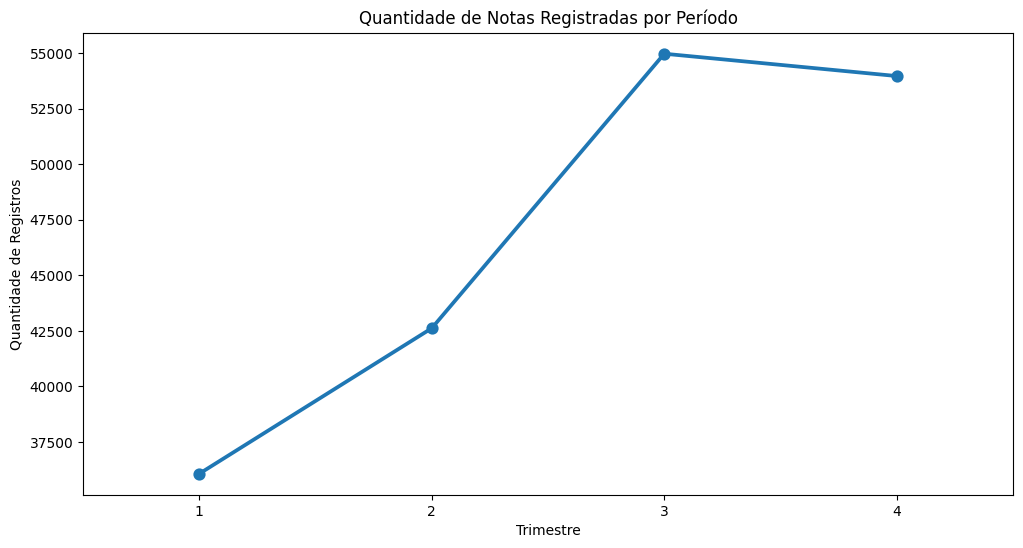

In [17]:
# Plotando gráfico da quantidade de notas registradas por trimestre
plt.figure(figsize=(12,6))
sns.pointplot(data=df.groupby(by='Trimestre')['Data Registro'].count())
plt.title('Quantidade de Notas Registradas por Período')
plt.ylabel('Quantidade de Registros')
plt.show()

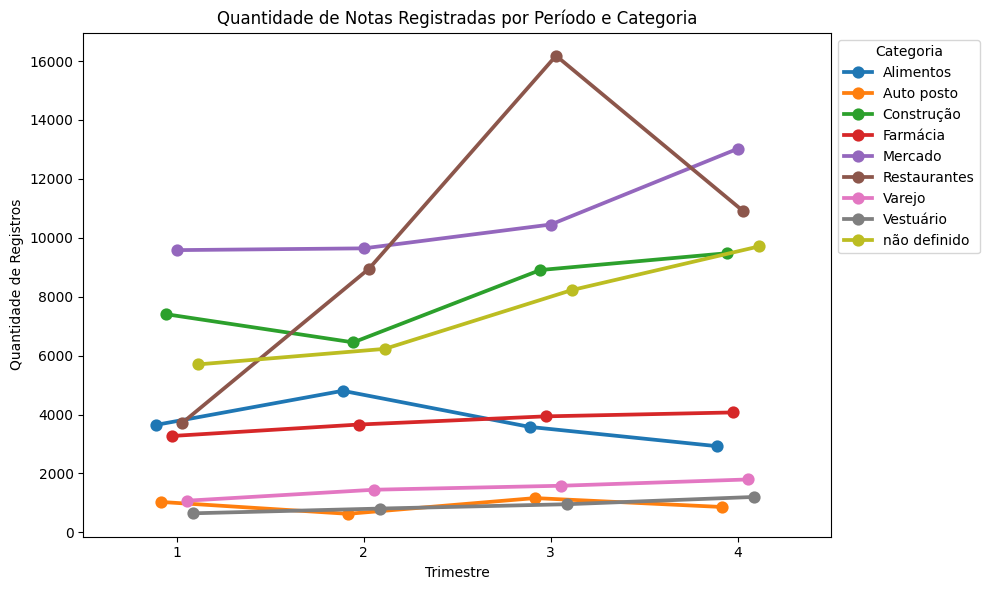

In [18]:
# Agrupando dados por trimestre e categoria
count_data1 = df.groupby(by=['Trimestre', 'categoria'])['Data Registro'].count().reset_index(name='count')

# Plotando gráfico de notas registradas por perídio e categoria
plt.figure(figsize=(10, 6))
sns.pointplot(data=count_data1, x='Trimestre', y='count', hue='categoria', markers='o', linestyles='-', dodge=True)

plt.title('Quantidade de Notas Registradas por Período e Categoria')
plt.xlabel('Trimestre')
plt.ylabel('Quantidade de Registros')
plt.legend(title='Categoria', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

In [19]:
# Agrupando dados por trimestre, categoria e evento
count_data2 = df.groupby(by=['Trimestre', 'categoria', 'flag_credito'])['Data Registro'].count().reset_index(name='count')
count_data2

Trimestre     categoria  flag_credito  count
0           1     Alimentos             0    439
1           1     Alimentos             1   3208
2           1    Auto posto             0    979
3           1    Auto posto             1     54
4           1    Construção             0   4374
..        ...           ...           ...    ...
67          4        Varejo             1    320
68          4     Vestuário             0    617
69          4     Vestuário             1    585
70          4  não definido             0   5057
71          4  não definido             1   4649

[72 rows x 4 columns]

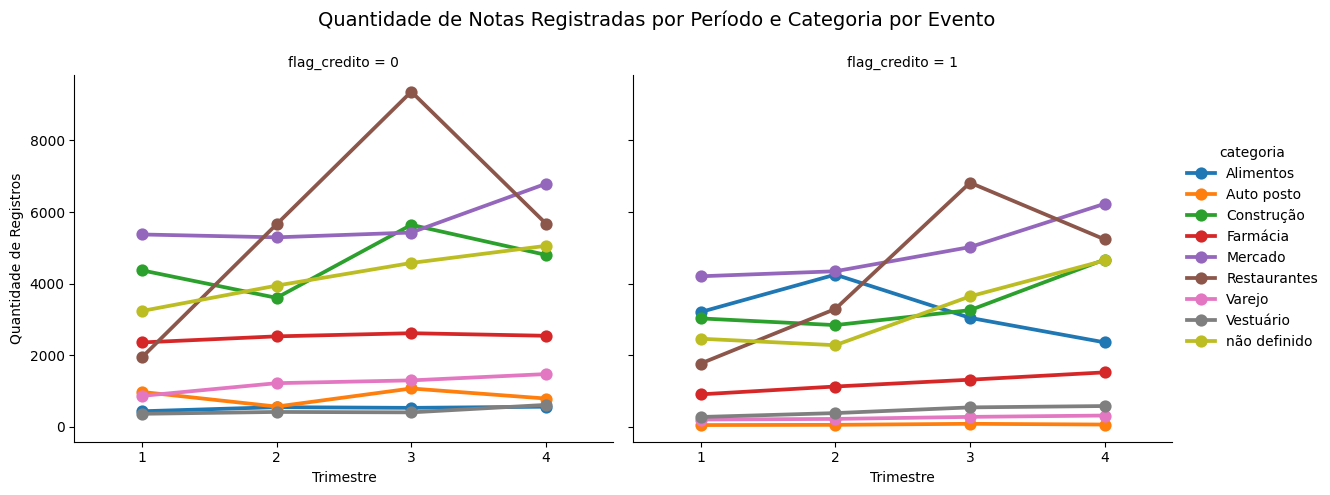

In [20]:
# Plotando gráfico dos eventos por trimestre e categoria
g = sns.FacetGrid(count_data2, col='flag_credito', hue='categoria', sharey=True, height=5, aspect=1.2)

g.map_dataframe(sns.pointplot, x='Trimestre', y='count', marker='o', linestyle='-', dodge=True)
g.add_legend()
g.fig.suptitle('Quantidade de Notas Registradas por Período e Categoria por Evento', fontsize=14)
g.set_ylabels('Quantidade de Registros')

plt.subplots_adjust(top=0.85)
plt.show()

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

In [14]:
# Contagem de total de observações e eventos por categoria
grouped = df.groupby('categoria')['flag_credito'].agg(['count', 'sum'])
grouped.columns = ['total', 'positivo']  

# Calcular quantidade de não eventos
grouped['negativo'] = grouped['total'] - grouped['positivo']

# Número total de eventos e não eventos
total_eventos = grouped['positivo'].sum()
total_não_eventos = grouped['negativo'].sum()

# Distribuições de evento e não eventos
grouped['evento_dist'] = grouped['positivo'] / total_eventos
grouped['não_evento_dist'] = grouped['negativo'] / total_não_eventos

grouped

total  positivo  negativo  evento_dist  não_evento_dist
categoria                                                            
Alimentos     14960     12868      2092     0.152036         0.020309
Auto posto     3689       271      3418     0.003202         0.033182
Construção    32236     13811     18425     0.163177         0.178870
Farmácia      14940      4886     10054     0.057728         0.097604
Mercado       42695     19808     22887     0.234032         0.222187
Restaurantes  39749     17118     22631     0.202250         0.219701
Varejo         5904      1035      4869     0.012229         0.047268
Vestuário      3612      1799      1813     0.021255         0.017601
não definido  29861     13042     16819     0.154092         0.163279

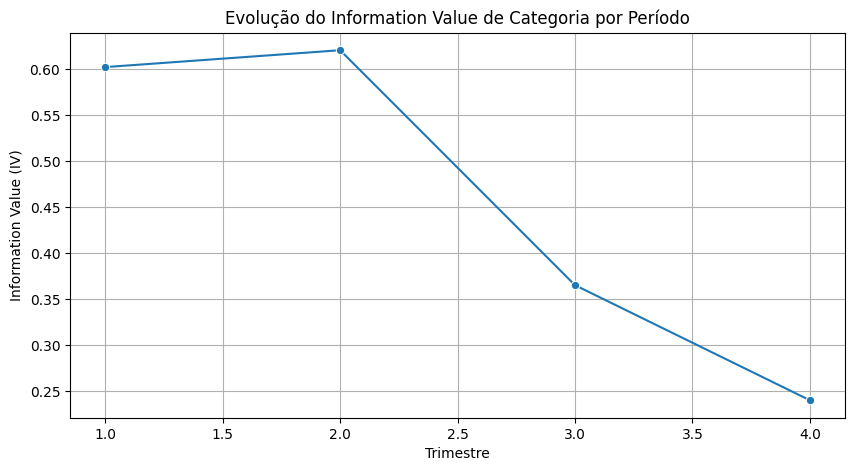

In [21]:
# Lista vazia para armazenar IV
iv_results = []

# Calculando IV para cada trimestre
for periodo, subset in df.groupby('Trimestre'):
    iv_value = calcular_iv_variavel(df=subset, var_estudada='categoria', var_evento='flag_credito')
    iv_results.append({'Trimestre': periodo, 'IV': iv_value})

# Transformando lista com dict em dataframe
iv_df = pd.DataFrame(iv_results)

# Plotando gráfico
plt.figure(figsize=(10, 5))
sns.lineplot(data=iv_df, x='Trimestre', y='IV', marker='o', linestyle='-')
plt.title('Evolução do Information Value de Categoria por Período')
plt.xlabel('Trimestre')
plt.ylabel('Information Value (IV)')
plt.grid()
plt.show()

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

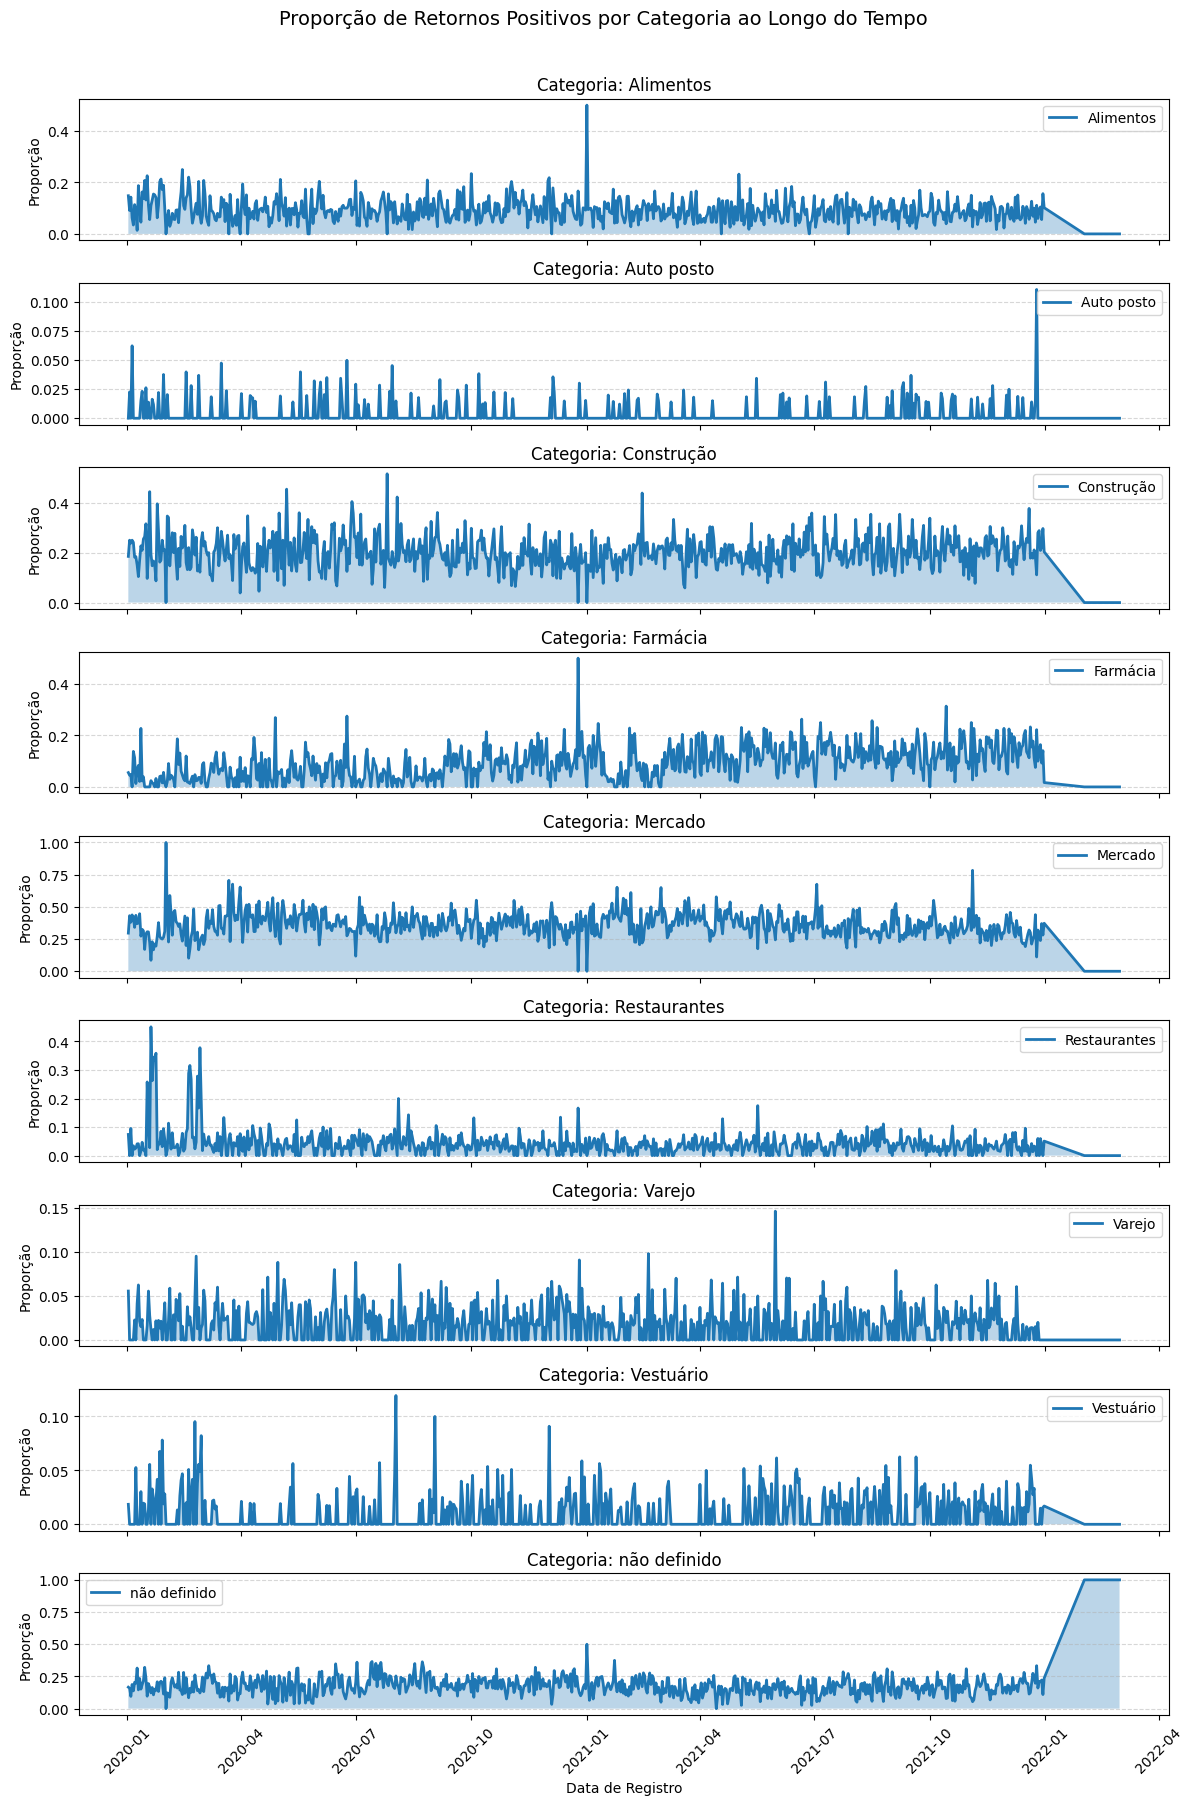

In [33]:
# Trabalhando com recorte temporal a partir de 2020
df_sub = df.loc[(df['Data Emissão'].dt.year >= 2020)].copy()

# Agrupando por data e categoria, somando os eventos positivos 
df_grouped = df_sub[df_sub['flag_credito'] == 1].groupby(['Data Registro', 'categoria']).size().unstack(fill_value=0)

# Calculando a proporção de cada categoria dentro de cada data
df_prop = df_grouped.div(df_grouped.sum(axis=1), axis=0)

# Criando os subplots (um para cada categoria)
num_categorias = len(df_prop.columns)
fig, axes = plt.subplots(nrows=num_categorias, ncols=1, figsize=(12, 2 * num_categorias), sharex=True)

# Criando um gráfico separado para cada categoria
for ax, categoria in zip(axes, df_prop.columns):
    ax.plot(df_prop.index, df_prop[categoria], label=categoria, linewidth=2)
    ax.fill_between(df_prop.index, df_prop[categoria], alpha=0.3)
    ax.set_ylabel('Proporção')
    ax.set_title(f'Categoria: {categoria}')
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.5)

# Ajustando layout e rótulos finais
plt.xlabel('Data de Registro')
plt.suptitle('Proporção de Retornos Positivos por Categoria ao Longo do Tempo', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.xticks(rotation=45)

# Exibir o gráfico
plt.show()

In [39]:
df_prop.mean()

categoria
Alimentos       0.091597
Auto posto      0.003688
Construção      0.201385
Farmácia        0.092794
Mercado         0.361395
Restaurantes    0.041981
Varejo          0.018430
Vestuário       0.010196
não definido    0.178533
dtype: float64

In [41]:
df_prop.var()

categoria
Alimentos       0.002086
Auto posto      0.000094
Construção      0.004552
Farmácia        0.004180
Mercado         0.009701
Restaurantes    0.002098
Varejo          0.000413
Vestuário       0.000282
não definido    0.006297
dtype: float64

A categoria **Alimentos**, com base nos gráficos no notebook anterior, é a categoria com a maior proporção de notas com retorno positivo. Já considerando o gráfico e informações acima, observamos que essa propriedade da categoria não se mantem ao longo do tempo. A categoria que mais se manteve estável ao longo do período foi **Auto posto**, com uma média do período igual a 0.36% da composição de retorno positivo em suas notas. A categoria com a maior média ao longo do período foi **Alimentos** com 36% da composição média de notas com retorno positivo ao longo do tempo. 